@akamsali:
modified from the backprop_and_update_params_one_neuron_model method in the ComputationalGraphPrimer class
in the ComputationalGraphPrimer.py file.

The modification is to use the SGD+ algorithm to update the step size

from:

$p_{t+1} = p_t - \eta g_{t+1}$

to:

$m_{t+1} = \beta_1 * m_t + (1-\beta_1) * g_{t+1}$

$v_{t+1} = \beta_2 * v_t + (1-\beta_2) * g_{t+1}^2$

$p_{t+1} = p_t - \eta (\hat{m}_{t+1} / \sqrt{\hat{v}_{t+1}})$

$\hat{m}_{t+1} = m_{t}/(1 - \beta_1^t)$

$\hat{v}_{t+1} = v_{t}/(1 - \beta_2^t)$


where m and v are the first and second momentum parameters

\eta = learning rate

$g_{t+1}$ = gradient of the loss function with respect to the learnable parameters (input val * deriv_sigmoid)

$p_t$ = learnable parameters

$m_0$ = all 0's

$v_0$ = all 0's




In [1]:
from ComputationalGraphPrimer import ComputationalGraphPrimer
import random
import numpy as np
import operator
# from tqdm import tqdm

class myADAM(ComputationalGraphPrimer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def backprop_and_update_parama_bias(self, y_error, vals_for_input_vars, deriv_sigmoid):
        """
  
        """

        input_vars = self.independent_vars
        vals_for_input_vars_dict = dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        for i, param in enumerate(self.vals_for_learnable_params):
            ## Calculate the next step in the parameter hyperplane
            g_t = y_error * vals_for_input_vars_dict[input_vars[i]] * deriv_sigmoid
            m_val = self.beta_1 * self.m[param] + (1-self.beta_1) * g_t
            v_val = self.beta_2 * self.v[param] + (1-self.beta_2) * (g_t**2)
            m_hat = m_val / (1 - self.beta_1 ** self.time[param] )
            v_hat = v_val / (1 - self.beta_2 ** self.time[param] )

            step = self.learning_rate * m_hat / np.sqrt(v_hat + self.epsilon)
            ## Update the learnable parameters
            self.vals_for_learnable_params[param] += step
            self.m[param] = m_val
            self.v[param] = v_val
            self.time[param] += 1

        ## Update the bias
        m_bias_val = self.beta_1 * self.m_bias + (1 - self.beta_1) * (y_error * deriv_sigmoid)
        v_bias_val = self.beta_2 * self.v_bias + (1 - self.beta_2) * ((y_error * deriv_sigmoid)**2)

        m_bias_hat = m_bias_val / (1 - (self.beta_1 ** self.time_bias))
        v_bias_hat = v_bias_val / (1 - (self.beta_2 ** self.time_bias))
        bias_step = self.learning_rate * (m_bias_hat / np.sqrt(v_bias_hat + 1e-7)) 
        self.time_bias += 1
        self.bias += bias_step
        self.m_bias = m_bias_val
        self.v_bias = v_bias_val


    def train(self, training_data, beta_1=0.9, beta_2=0.99, epsilon=1e-7):
        """
        @akamsali: Taking Avi's code as is for training a one neuron model.  The only modification
        is to return the loss running record so that we can plot it later.
        """

        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """

        self.vals_for_learnable_params = {
            param: random.uniform(0, 1) for param in self.learnable_params
        }

        self.bias = random.uniform(
            0, 1
        )  ## Adding the bias improves class discrimination.
        ##   We initialize it to a random number.
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon 
        self.m = {param: 0 for param in self.learnable_params}
        self.v = {param: 0 for param in self.learnable_params}
        self.time = {param: 1 for param in self.learnable_params}
        self.time_bias = 1
        self.m_bias = 0
        self.v_bias = 0

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)

            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """

            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [
                    (item, 0) for item in self.training_data[0]
                ]  ## Associate label 0 with each sample
                self.class_1_samples = [
                    (item, 1) for item in self.training_data[1]
                ]  ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):
                cointoss = random.choice(
                    [0, 1]
                )  ## When a batch is created by getbatch(), we want the
                ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)

            def getbatch(self):
                batch_data, batch_labels = (
                    [],
                    [],
                )  ## First list for samples, the second for labels
                maxval = 0.0  ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval:
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [
                    item / maxval for item in batch_data
                ]  ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = (
            0.0  ##  Average the loss over iterations for printing out
        )



        ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids = self.forward_prop_one_neuron_model(
                data_tuples
            )  ##  FORWARD PROP of data
            loss = sum(
                [
                    (abs(class_labels[i] - y_preds[i])) ** 2
                    for i in range(len(class_labels))
                ]
            )  ##  Find loss
            loss_avg = loss / float(len(class_labels))  ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg
            if i % (self.display_loss_how_often) == 0:
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                # print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0  ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(
                map(
                    operator.truediv,
                    data_tuple_avg,
                    [float(len(class_labels))] * len(class_labels),
                )
            )
            self.backprop_and_update_parama_bias(
                y_error_avg, data_tuple_avg, deriv_sigmoid_avg
            )  ## BACKPROP loss
        # plt.figure()
        return loss_running_record
        # plt.show()


/home/akshita/anaconda3/envs/ece60146/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




all variables: {'xd', 'xw', 'xc', 'xa', 'xb'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xd', 'xc', 'xa', 'xb']


leads_to dictionary: {'xd': {'xw'}, 'xw': set(), 'xc': {'xw'}, 'xa': {'xw'}, 'xb': {'xw'}}


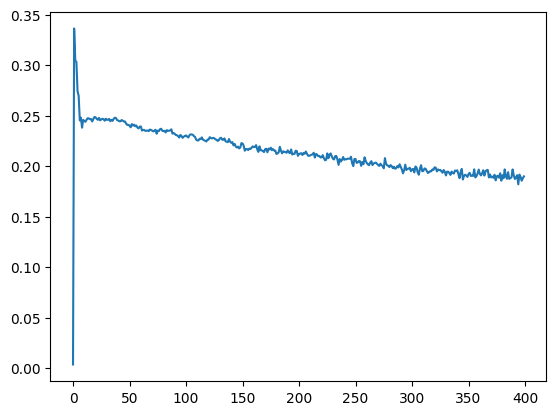

In [2]:


cgp = myADAM(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


cgp.parse_expressions()
training_data = cgp.gen_training_data()

# loss_0 = cgp.train(training_data)
loss = cgp.train(training_data)
plt.plot(loss)

# loss_9 = cgp.train(training_data, mu=0.9)
# plt.plot(loss_0)
# plt.plot(loss_9)